# Project: Stroke Prediction 

## Introduction

According to American Stroke Association, a stroke happens when a blood vessel that carries oxygen and nutrients to the brain is clogged by a clot or bursts. When this occurs, a part of the brain which controls a particular body function cannot get the blood flow going, so it and that part of the body will be damaged. 

Based on the World Health Organization (WHO) report of 2020, stroke ranked as the second-leading cause of death globally. It is also one of the top ten leading causes of death across all income groups worldwide. In general, it is responsible for approximately 11% of total deaths. Despite the fact that there are many people who survive a stroke, at least half of them still suffer the aftereffects of stroke such as pain, numbness, problems with balance or coordination, and so on. Hence, we should shed some light on the causes of this disease.

In this project, we are going to explore what factors are associated with a higher risk of stroke. These factors include age, gender, health condition, living, and working conditions. We will also use these factors to run some predictive binary classification models such as logistic regression to figure out which model performs the best when predicting whether an individual has a stroke or not. 

## Setup

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score


Bad key "text.kerning_factor" on line 4 in
/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Part I. Dataset Overview 

First, we will take a qucik look of the dataset, including:

- Summary of the dataset and basic statistics of the variables 
- Check if there is any missing values in the dataset, if so, fill in NAs 

In [2]:
health = pd.read_csv("stroke.csv")
health.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
## summary of the dataset(type of data in each column, shape of the dataset)
health.info()
health.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


(5110, 12)

The dataset has 5110 rows and 12 columns. Each row represents an individual and contains information such as the age of this individual. If we look closely at the dataset, we can see the dataset has both numerical and categorical variables. Also, some categorical variables in the dataset are shown in numerical form. For instance, 1 means an individual has hypertension while 0 does not. This applies to the variable heart disease and stroke too. 

In [4]:
## check if there is any missing values
health.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The above shows only the BMI column has 201 missing values. One common way to fill missing values is through mean imputation, and we apply this method below. 


According to the Centers for Disease Control and Prevention (CDC), although BMI is calculated with the same method for both adults and children, their results can be interpreted differently. Specifically, BMI does not depend on age or sex for adults who are 20 years and older. However, for children and teenagers under 20 years old, BMI is considered related to age and sex since the amount of body fatness varies by sex and changes with age. Thus, we need to take age and gender into account for those younger than 20 years when filling in the NAs.

In [5]:
## Divide the data into two groups based on age 
adult = health[health['age'] >= 20]
teen = health[health['age'] < 20]

In [6]:
## Find out the mean of bmi for each group 
adult_bmi_mean = adult['bmi'].mean()
teen_bmi_mean = teen.groupby(['gender'])['bmi'].mean()

In [7]:
## Fill in NAs with mean for each group 
adult['bmi'].fillna(adult_bmi_mean, inplace = True)
teen['bmi'].fillna(teen.groupby('gender')['bmi'].transform('mean'), inplace = True)

/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [8]:
## Combine the two tables back
health = pd.concat([adult, teen], axis = 0)

In [9]:
## check if there is still missing values in the dataset
health.isnull().sum() 

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## II. Exploratory Data Analysis (EDA)

After getting the overview of the dataset, we are going to dive deep and explore relationships between variables.

#### a. Numerical variables overview

In [10]:
## Basic statistics of the numerical variables
health.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.921170,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.717532,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.625000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.300000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
## Correlations between the numerical variables 
corr_mat = health.select_dtypes(include=np.number).corr()
corr_mat.iloc[:,-1].sort_values(ascending = False)

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.044811
id                   0.006388
Name: stroke, dtype: float64

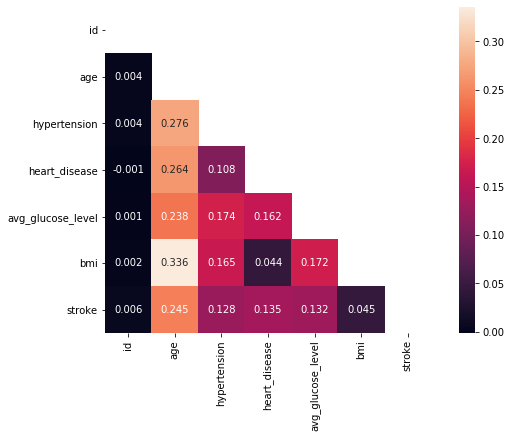

In [12]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(10,6))
sns.heatmap(health.corr(), annot = True, fmt='.3f', mask = mask, square = True)

The numerical variable that has the highest correlation with stroke is age, whereas id has the lowest correlation with stroke. However, individuals' ids are just numbers that uniquely identify each individual in the dataset. For this reason, the id column can be ignored when we try to predict the occurrence of stroke. 

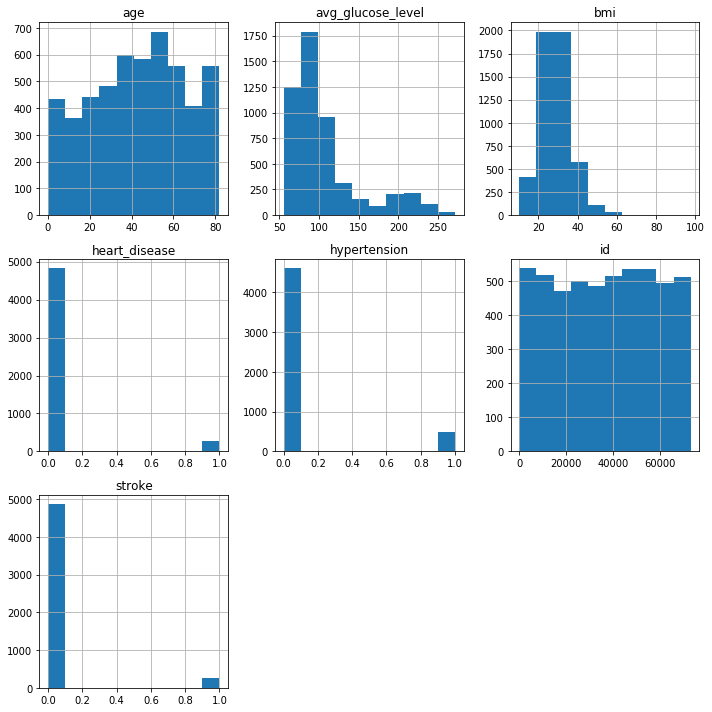

In [13]:
## Overall distributions of the numerical variables 
health.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

The distribution plots of heart disease, hypertension, and stroke show most individuals in the dataset do not suffer from these diseases, which means the distributions are not even. We should pay attention to stroke in particular since it presents class imbalance. Consequently, we may want to use the evaluation metric confusion matric as well as the K-fold cross-validation to resolve this problem.

#### b. Categorical Variables Overview

In [14]:
## Count the amount of unique values for each categorical variable 
health['ever_married'].value_counts()
health['work_type'].value_counts()
health['Residence_type'].value_counts()
health['smoking_status'].value_counts()
health['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Gender'),
 Text(0.5, 1.0, 'Gender Frequency')]

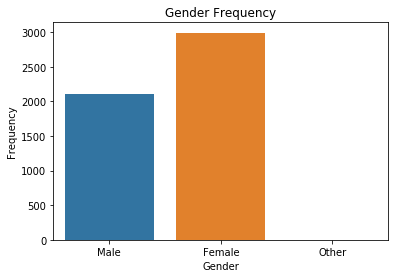

In [15]:
## Using seaborn to plot distribution of the gender data 
ax = sns.countplot(x = 'gender', data = health)
ax.set(title = "Gender Frequency", xlabel = "Gender", ylabel = "Frequency")

/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

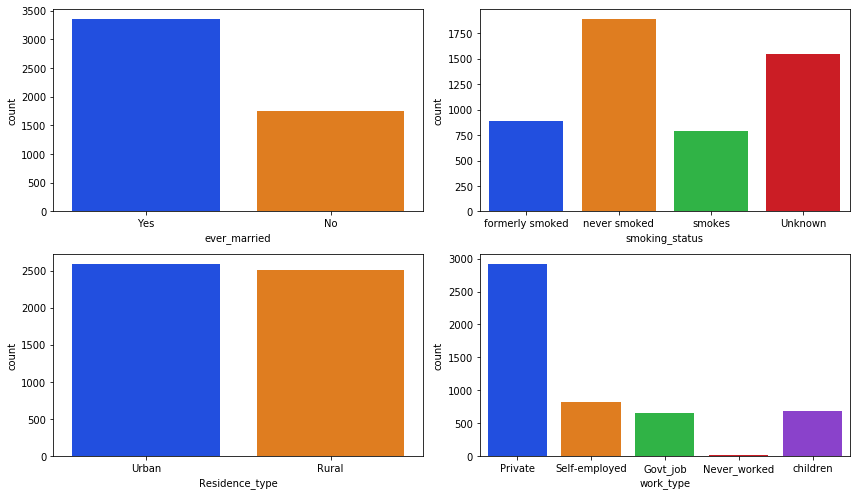

In [16]:
## Subset the categorical data from the dataset first
categorical = pd.DataFrame(health.select_dtypes(include = np.object))

## Frequency plots that show the counts of observations in each categorical variable using bars
fig, axes =plt.subplots(2,2,figsize=(12,7))
sns.countplot(categorical['ever_married'], ax=axes[0][0], palette = "bright")
sns.countplot(categorical['smoking_status'], ax=axes[0][1], palette = "bright")
sns.countplot(categorical['Residence_type'], ax=axes[1][0], palette = "bright")
sns.countplot(categorical['work_type'], ax=axes[1][1], palette = "bright")

plt.tight_layout()

#### c. Relationships Between Variables

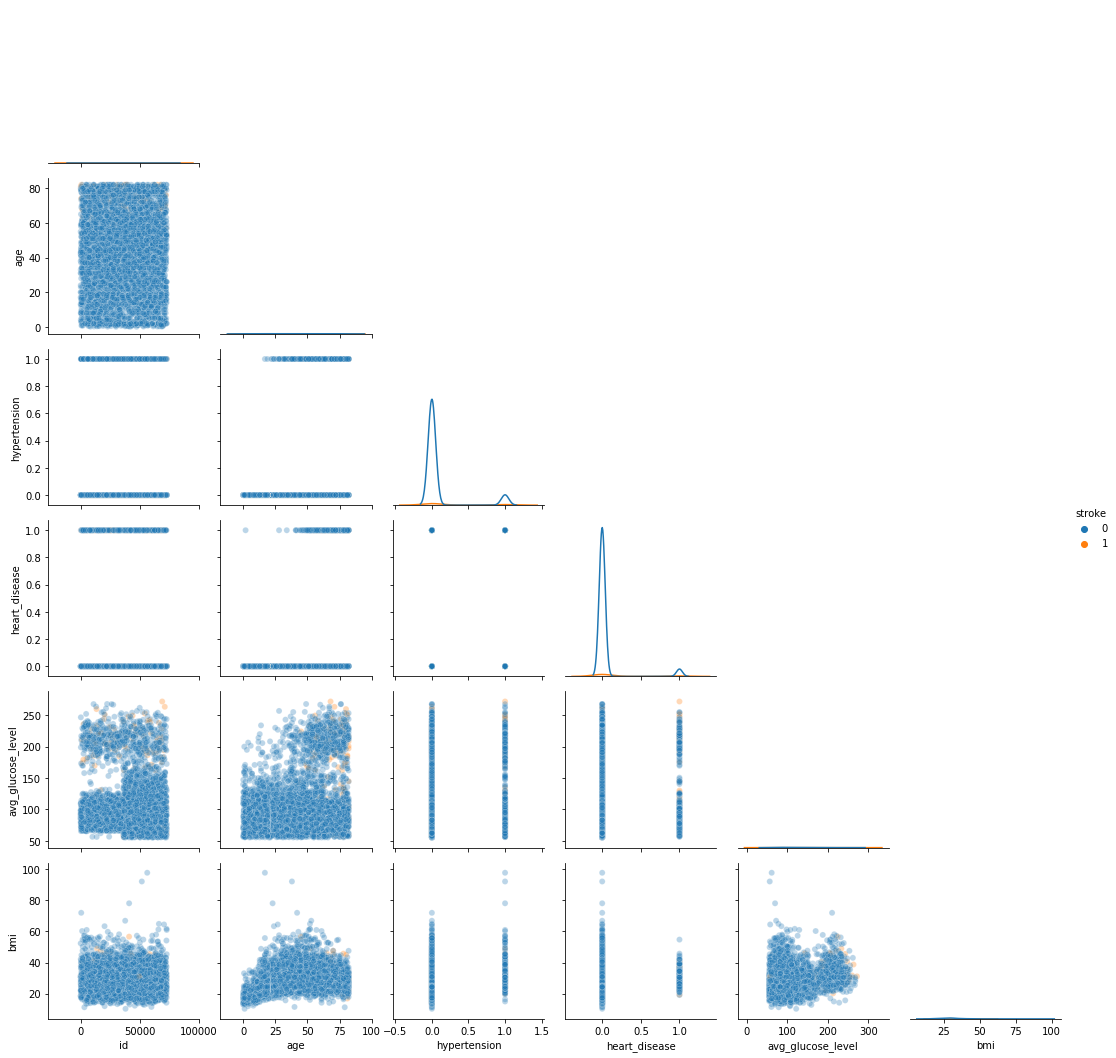

In [17]:
## Pairplot to check if there is any collinearity between the numerical variables
plot = sns.PairGrid(health, corner = True, hue = 'stroke')
plot.map_diag(sns.kdeplot)
plot.map_lower(sns.scatterplot,alpha = 0.3)
plot.add_legend()

While grouping by the occurrence of stroke, older individuals who have stroke gather at high average glucose levels. This is reasonable since they have been exposed to sugar longer than the ones who are younger, so their chances of developing abnormal blood glucose level are greater, and high blood glucose level is associated with stroke. 


We can also see individuals who have a stroke and high BMI tend to cluster at high average glucose levels. This makes sense because stroke risk increases with age and obesity. In addition, BMI seems to have a positive relationship with age and average glucose level. We will have a closer look at them in the plots which follow. 

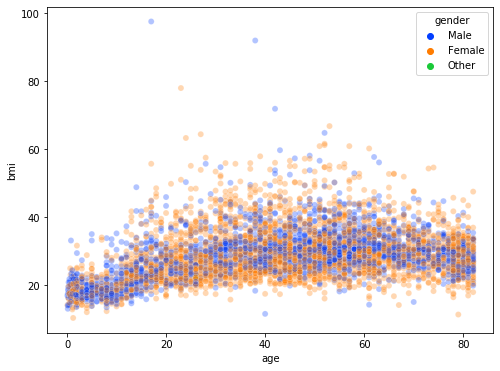

In [18]:
## Concat hypertension, heart disease, and stroke to the categorical dataset
health_condition = pd.concat([health['hypertension'], health['heart_disease'], health['stroke']], axis = 1)
categorical = pd.concat([categorical, health_condition], axis = 1)

fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(x = 'age' , y = "bmi" , hue = 'gender', data = health, alpha = 0.3,palette="bright")

From the plot above, we can see there is a trend that BMI increases as age increases until the age hits 20, and the BMI seems to flatten out after that. In addition, data points of females and males with BMI and age information are scattering in the plot, which indicates that gender does not play a big role in deciding someone's BMI overall.

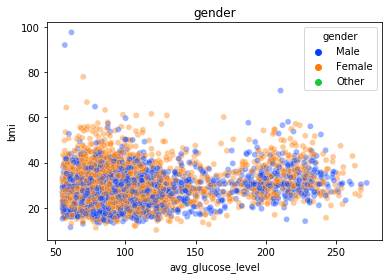

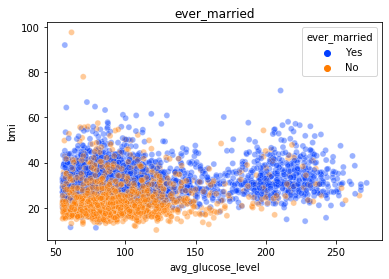

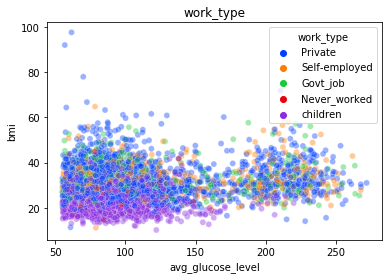

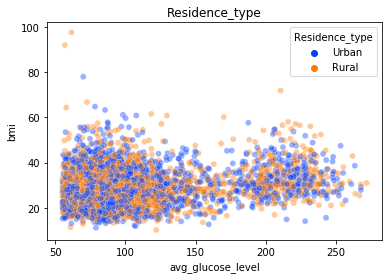

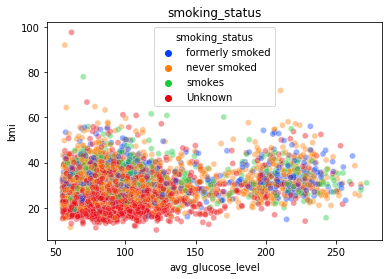

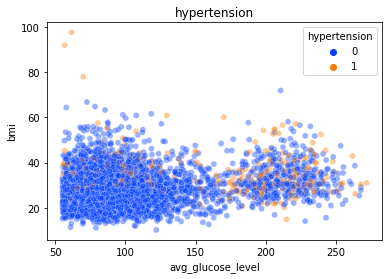

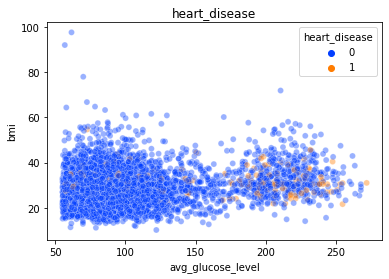

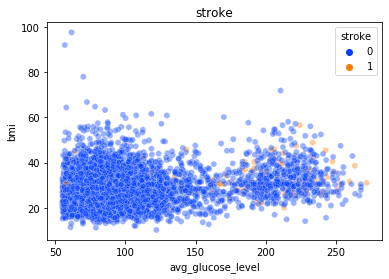

In [19]:
## Find relations or trends considering multiple variables
for i , r in enumerate(categorical):
        plt.subplots(figsize=(6,4))
        plt.title(r)
        sns.scatterplot(x = 'avg_glucose_level' , y = "bmi" , hue = r, data = health, alpha = 0.4,palette="bright")

In general, there is a positive relationship between BMI and average glucose level, though they are grouped by different variables. In other words, BMI increases as the average glucose level increases. This is expected since as BMI increases, insulin resistance also increases, which will lead to an increase in blood glucose levels in the body. 

##### Age

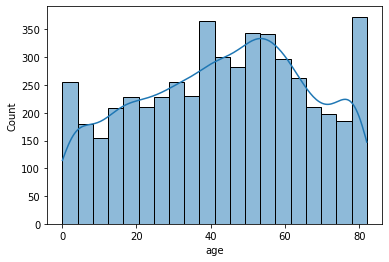

In [20]:
## count the number of people in different age (closer look)
sns.histplot(data = health, x = 'age', kde = True)

In [23]:
## Number of people in each age group 
bins = np.arange(0.00, 95.00, 10.00)
health['id'].groupby(pd.cut(health['age'], bins)).count()

age
(0.0, 10.0]     507
(10.0, 20.0]    518
(20.0, 30.0]    545
(30.0, 40.0]    674
(40.0, 50.0]    739
(50.0, 60.0]    823
(60.0, 70.0]    594
(70.0, 80.0]    594
(80.0, 90.0]    116
Name: id, dtype: int64

/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'People with Stroke'),
 Text(0.5, 0, 'Age'),
 Text(0.5, 1.0, 'Age vs. Stroke')]

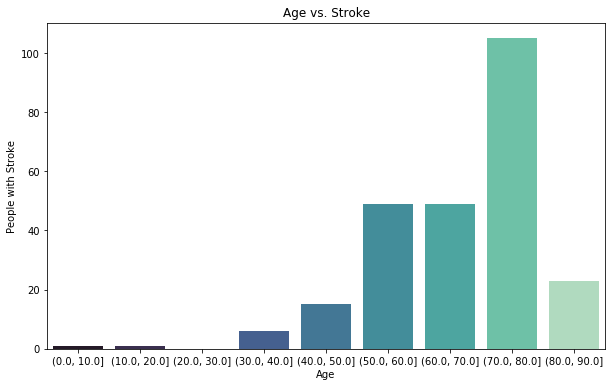

In [24]:
## Create bins for age and check which age groups have the most number of people with stroke 
age = health['stroke'].groupby(pd.cut(health['age'], bins)).sum()
age = pd.DataFrame(age).reset_index()
age.columns = ['Age_range', 'Num_stroke']

plot_size = (10,6)
fig, ax = plt.subplots(figsize=plot_size)
ax2 = sns.barplot('Age_range', 'Num_stroke', data = age, palette = 'mako')
ax2.set(title='Age vs. Stroke', xlabel = 'Age', ylabel = 'People with Stroke')

The plot above implies older people tend to have a higher chance of getting a stroke in general. The huge decline of cases of stroke in the age group of 80-90 maybe because there are fewer people who can live beyond the average human life expectancy of America, which is approximately 79 years old. The record of the amount people who have a stroke in this age group decreases in consequence of decreasing population.

##### Check out relations considering multiple variables 

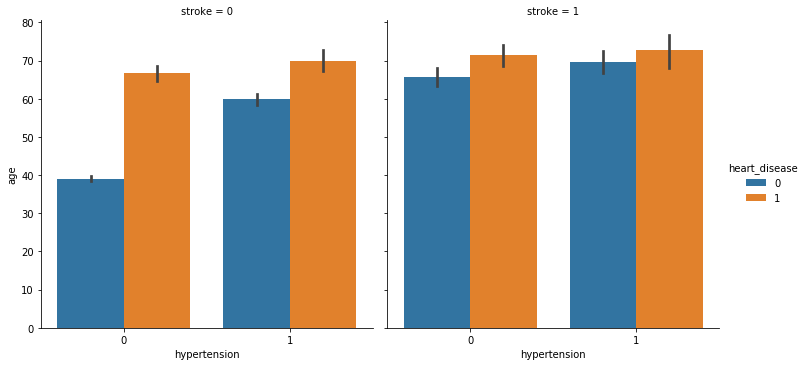

In [25]:
sns.catplot(x = 'hypertension', y = 'age', hue = 'heart_disease', col = 'stroke', 
            data = health, kind = 'bar')

Generally, older individuals are more likely to have a stroke as well as heart disease. They have a higher chance of getting hypertension as well. 

##### Avgerage Glucose Level

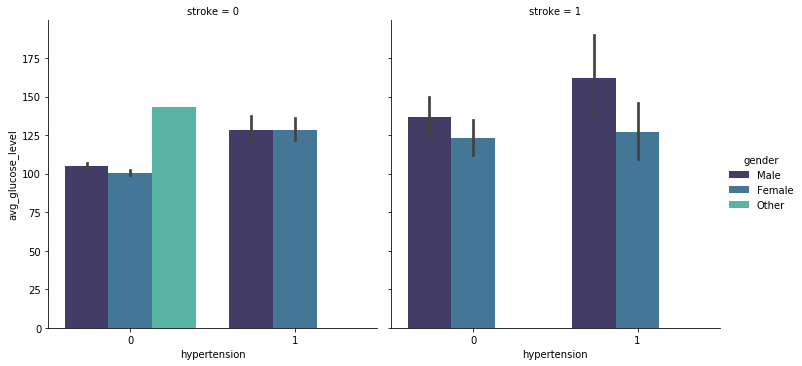

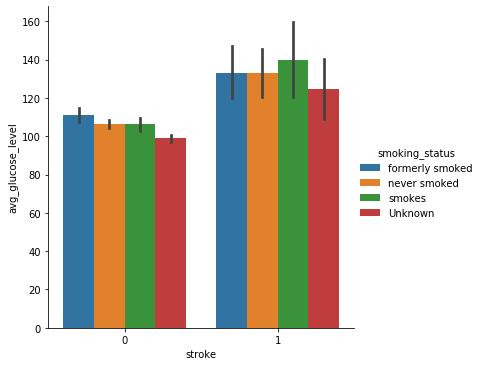

In [26]:
sns.catplot(x = 'hypertension', y = 'avg_glucose_level', hue = 'gender', col = 'stroke', 
            data = health, kind = 'bar', palette = "mako")

sns.catplot(x = 'stroke', y = 'avg_glucose_level', hue = 'smoking_status', 
            data = health, kind = 'bar', palette = "tab10")

In the first set of subplots above, we can see people who have a stroke are more likely to have hypertension and high average glucose level. If we just focus on the ones that have a stroke, we can see females have higher glucose levels than males on average. However, for the ones who do not have a stroke, it is hard to tell which gender has a higher average glucose level. We can not say much about the gender 'other' since there is only one individual has been identified as 'other', so we may treat this individual as an outlier. 


In the second subplot above, people who have stroke tend to have higher average glucose level than the ones do not have stroke regardless of their smoking status. 

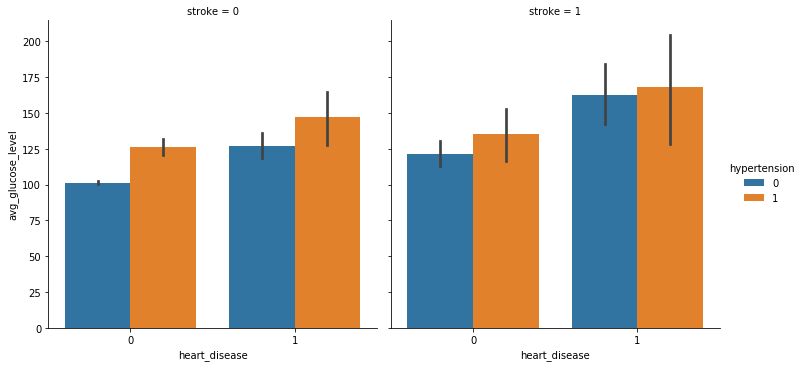

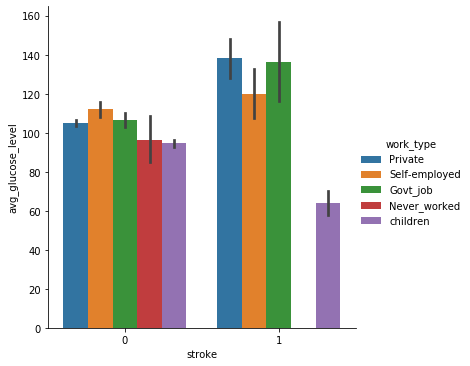

In [27]:
sns.catplot(x = 'heart_disease', y = 'avg_glucose_level', hue = 'hypertension', col = 'stroke', 
            data = health, kind = 'bar', palette = "tab10")

sns.catplot(x = 'stroke', y = 'avg_glucose_level', hue = 'work_type', 
            data = health, kind = 'bar', palette = "tab10")

The first set of subplots above illustrates that individuals who have heart disease and high average glucose level tend to have a stroke. 
The second set of subplots above shows that people who are smoking are more likely to have higher average glucose levels regardless of their work type.  

### Stroke

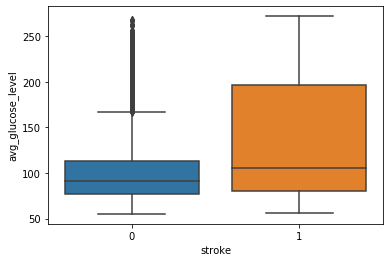

In [28]:
sns.boxplot(x = 'stroke', y = 'avg_glucose_level', data = health)

People with stroke have a wider range of average glucose levels and a higher median average glocuse level.

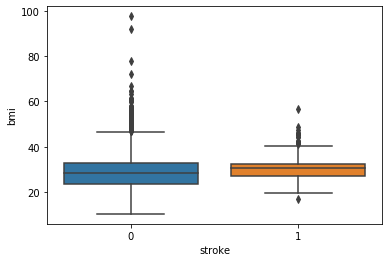

In [29]:
sns.boxplot(x = 'stroke', y = 'bmi', data = health)

Compared to people who do not have a stroke, the ones who do have a stroke have a narrower range of BMI. Also, we can see there are more extreme outliers, which means people with high BMI, appear in the group of people who do not have a stroke. Yet, both groups of people have a similar median BMI.

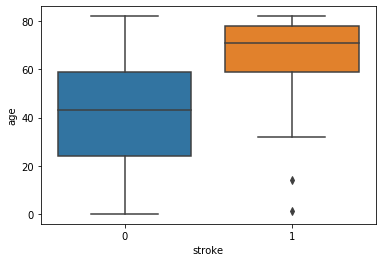

In [30]:
sns.boxplot(x = 'stroke', y = 'age', data = health)

The boxplot above shows that people who have a stroke have a higher median age than the ones who do not have a stroke. This further confirms that older people are more likely to have a stroke.

##### Summary of data visualizations

Some plots above do indicate there are relations between some of the variables and the occurrence of stroke. For instance, the risk of having stroke increases as age increases. Nevertheless, we cannot accurately predict whether a stroke will happen or not based on the information we gained from all the plots. Thus, we should approach the predictive part in another way, and that's when predictive modeling comes to play.

## Part III. Feature Engineering for ML algorithms

In this section, we are going to focus on organizing/cleaning data for the ML algorithms later on. The steps of preparing data are:

- Dropping values that may not be helpful in the predictive modeling 
- Convert the categorical variables to numerical 
- Standardize the data

##### Drop the 'id' column since it only represents individuals' identities

In [31]:
health.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [32]:
health.drop('id', axis = 1, inplace = True)

##### Drop the only row where the gender is 'other' since it can be seen as an outlier 

In [33]:
other_index = health[health['gender'] == 'Other'].index
health = health.drop(other_index)

##### Convert categorical variables to numerical

In [34]:
health_cat = health[['hypertension','heart_disease','gender', 'ever_married','smoking_status', 'Residence_type', 
                                                'work_type']]

In [35]:
cat_encoder = OneHotEncoder(sparse=False)
health_cat_1hot = cat_encoder.fit_transform(health_cat)
health_cat_1hot

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.]])

In [36]:
cat_encoder.categories_

[array([0, 1]),
 array([0, 1]),
 array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
       dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object)]

##### Standardize the numerical values since they all use different scales

In [37]:
numerical = health[['age','avg_glucose_level', 'bmi']]

scaler = StandardScaler()
numerical = scaler.fit_transform(numerical)
numerical

array([[ 1.05124201,  2.70644995,  0.99488928],
       [ 0.78588869,  2.12165168,  0.20976617],
       [ 1.6261742 , -0.00486741,  0.46359424],
       ...,
       [-1.51384008, -0.75662471, -1.48016809],
       [-1.1158101 , -0.51435745,  2.32960608],
       [-1.33693787, -0.06758747, -1.33762552]])

In [38]:
## Combine the standardized numerical variables with the encoded categorical variables
stroke = np.c_[numerical, health_cat_1hot, health['stroke']]

In [39]:
## First split the variables into two group. X: predictive variables for stroke, Y: stroke 
x = stroke[:,:-1]
y = stroke[:,-1]

## Assign randomly 80% of the data as training data, and 20% as testing data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

## Part IV. Predictive Modeling

Some common models for bianry classification are:

- Logistic Regression 
- k-Nearest Neighbors
- Decision Trees 
- Support Vector Classifier
- Random Forest

Now, we will conduct predictive classification modeling by using the models above. After running the basic algorithms, we will also use the confusion matrix to check the models' performance. In addition, we are going to use k-fold cross-validation to improve the models' accuracy.

#### a. Logistic Regression

In [40]:
log_reg = LogisticRegression(random_state=42).fit(x_train, y_train)
log_pred = log_reg.predict(x_test)

#### b.K-Nearest Neighbors

In [41]:
knn = KNeighborsClassifier(n_neighbors=2).fit(x_train, y_train)
knn_pred = knn.predict(x_test)

#### c. Support Vector Classifier(SVC)

In [42]:
svc = SVC().fit(x_train, y_train)
svc_pred = svc.predict(x_test)

#### d. Decision Tree

In [43]:
tree = DecisionTreeClassifier(random_state = 0).fit(x_test, y_test)
tree_pred = tree.predict(x_test)

#### e. Random Forest

In [44]:
forest = RandomForestClassifier(random_state = 0).fit(x_test, y_test)
forest_pred = forest.predict(x_test)

##### Create confusion matrix and check accuracy rate and error rate for each classification model.

In [45]:
model_name = ['Log_Reg', 'KNN', 'SVC','Dec_Tree', 'Ram_Forest']
predict = [log_pred, knn_pred, svc_pred, tree_pred, forest_pred]

class_accuracy = []
class_error = []
roc_auc_score = []

for i in predict:
    mat = metrics.confusion_matrix(y_test, i)
    
    # TP: True Positive, TN: True Negative, FP: False Positive, FN: False Negative 
    TP = mat[1, 1]
    TN = mat[0, 0]
    FP = mat[0, 1]
    FN = mat[1, 0]
    
    # calculate classification accuracy
    c_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    class_accuracy.append(c_accuracy)
    
    # calculate classification error
    c_error = (FP + FN) / float(TP + TN + FP + FN)
    class_error.append(c_error)
    
    
model_perfm = pd.DataFrame({'Model':model_name, 'Accuracy': class_accuracy, 
                            'Error': class_error})
model_perfm

,Model,Accuracy,Error
0,Log_Reg,0.940313,0.059687
1,KNN,0.938356,0.061644
2,SVC,0.940313,0.059687
3,Dec_Tree,1.000000,0.000000
4,Ram_Forest,1.000000,0.000000


The table above has shown us that Logistic Regression, K-Nearest Neighbor(K-NN), and Support Vector Classifier(SVC) all have an accuracy rate of around 94% and an error rate of around 6% in predicting the occurrence of stroke. On the other hand, the decision tree and random forest model both have 100% accuracy and 0% error, which is unusual. This might be caused by the models overfit the training dataset. Hence, we should perform k-fold cross-validation to avoid this problem.

### Stratified KFold Validation  

We will also use k-fold cross-validation to improve the accuracy of the models as it reduces overfitting and variance. As we can see below, there is a severe imbalanced distribution of classes in the training dataset, which has much more individuals do not have a stroke than individuals do have a stroke. Therefore, instead of using the standard k-fold cross-validation, we will apply the Stratified k-fold cross-validation here.

In [46]:
## Check the distribution of classes in the training dataset
np.unique(y_train,return_counts=True)

(array([0., 1.]), array([3899,  188]))

In [49]:
models = [LogisticRegression(), KNeighborsClassifier(),
          SVC(), DecisionTreeClassifier(), RandomForestClassifier()]

model_accur = []
model_std = []

for i in models:
    
    # Split the dataset randomly into 10 folds and perform cross validation 
    skf = StratifiedKFold(n_splits=5, random_state = 0)
    results = cross_val_score(i, x, y, cv=skf) 
    
    # Append the models' average accurracy and standard deviation to empty lists
    model_accur.append(results.mean())
    model_std.append(results.std())
    
models_perfm = pd.DataFrame({'CV_Accuracy': model_accur,
                     'CV_std': model_std})

/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/fenglanjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2

In [50]:
## Summary of models' performance in a table
models_performance = pd.concat([model_perfm,models_perfm], axis = 1)
models_performance.sort_values(by = 'CV_Accuracy', ascending = False)

,Model,Accuracy,Error,CV_Accuracy,CV_std
0,Log_Reg,0.940313,0.059687,0.951654,0.000767
2,SVC,0.940313,0.059687,0.951263,0.000373
4,Ram_Forest,1.000000,0.000000,0.948914,0.002416
1,KNN,0.938356,0.061644,0.947740,0.002722
3,Dec_Tree,1.000000,0.000000,0.902926,0.026255


After running the k-fold cross-validation, we can tell both the support vector classifier and the logistic regression have the highest accuracy rate, which is 95.1%. However, the support vector classifier surpasses the logistic regression with 0.00056 standard deviations, which means the data points tend to be very close to the mean, and thus less variation. For this reason, we can say the support vector classifier is the best classifier model among all the models. 

### Conclusion

In this project, we conducted an in-depth analysis of all the variables that may contribute to the occurrence of stroke. Although we can claim some variables such as age are positively correlated to stroke through the data visualizations, we still need a more efficient and accurate way to help us to predict if an individual has a stroke. Fortunately, predictive classification models can help us achieve that. In the previous section, we ran some basic binary classification models and used the confusion matrix to evaluate the models. Both the decision tree and random forest model presented 100% accuracy and 0% error, which suggested there might be a problem of overfitting. We then applied the k-fold cross-validation to resolve this problem while improving the models' performance. In the end, we figured the support vector classifier performed the best with 95.1% accuracy and 0.00056 standard deviations when predicting the occurrence of stroke.   

Due to the prevalence of stroke in the world, it is necessary to increase our awareness of this disease which is the second leading cause of death globally. Hopefully, this project gives people a sense of what factors are closely related to stroke and what groups of people are exposed to a higher risk of stroke so that we can try to adjust or change our lifestyles in order to avoid this disease at all cost.